In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#加载数据集
data  = np.load("./data/swissroll.npy")
color = np.load("./data/swissroll_color.npy")
learning_rate = 0.001
max_iter = 5000 
print(type(data))
print(np.shape(data))
data_tensor = torch.tensor(data,dtype=torch.float32)

<class 'numpy.ndarray'>
(1500, 3)


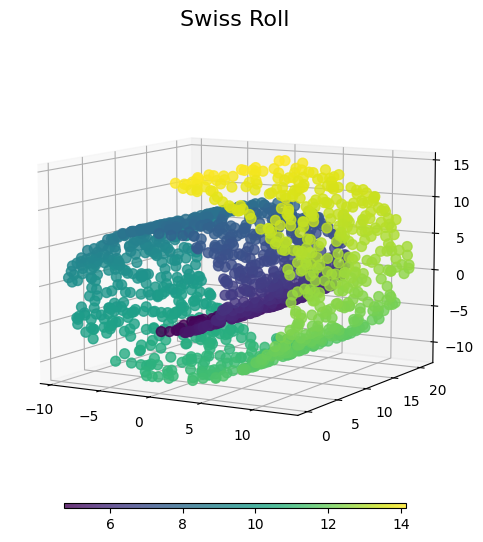

In [3]:
#降维前数据
from matplotlib import ticker
def plot_3d(points, points_color, title):    #依次传入数据点三维坐标，颜色，图表标题
    x, y, z = points.T

    fig, ax = plt.subplots(  #绘图并展示
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()
plot_3d(data, color, "Swiss Roll")

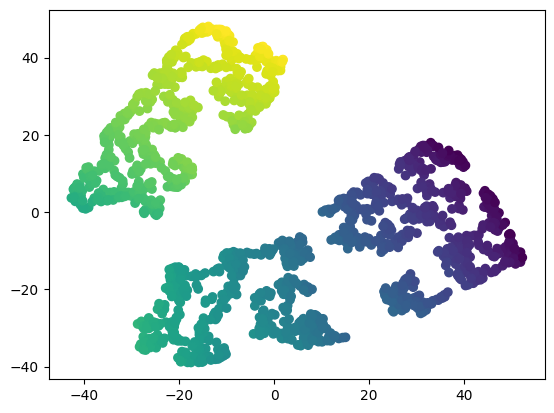

In [4]:
#sklearn中的t-sne方法
from sklearn.manifold import TSNE
data_embedded = TSNE(n_components=2,learning_rate=100,init='random').fit_transform(data)
plt.scatter(x=data_embedded[:,0],y=data_embedded[:,1],c=color)

### 训练前准备
1. 计算高维数据点之间的欧氏距离
2. 通过二分法计算每个点的beat(1/sigma2)
3. 计算高维数据之间的高斯分布
4. 将高维点代入神经网络，得到降维后低维空间的点
5. 计算低维数据点之间的概率分布
6. 迭代训练，调整参数，使得损失函数最小

注意：计算概率可使用numpy，应用到网络时必须用tensor计算

In [5]:
#计算高维数据欧氏距离，输入高维数据X(m维属性,n个实例)，输出n*n的距离矩阵
def cal_X_dist(X):
    sum_X = np.sum(np.square(X),axis=1)  #某点各个维度数据的平方和
    D = np.add(np.add(-2*np.dot(X,X.T),sum_X).T,sum_X)  #计算各点间距离(xi-xj)2,np.add将一维拓展为n维再相加，此时Dii=0
    return D

In [6]:
#计算各点的概率分布P，熵，输入高维数据间的距离，输出概率分布，熵
def cal_P_beta(D,beta):
    P = np.exp(-D*beta)
    sum_P = np.sum(P)
    #计算熵
    log_Per = np.log(sum_P)+beta*np.sum(np.multiply(D,P))/sum_P
    P = P/sum_P
    return log_Per,P

In [7]:
# 二值搜索，计算beta使得熵最接近logU;
# tol：差值小于该值则停止搜索；
# max_iter：最大搜索轮数
# 输入距离向量，该数据点的初始化beta，设定困惑度，输出最合适的beta以及此时的概率分布

def binary_search(D,init_beta,logU,tol=1e-5,max_iter=50):
    beta_max = np.inf
    beta_min = -np.inf
    beta = init_beta
    m_iter = 0
    cur_log,P = cal_P_beta(D,beta)
    diff_log_Per = cur_log - logU
    while np.abs(diff_log_Per) > tol and m_iter<max_iter:
        #当前熵较大，增大beta
        if diff_log_Per > 0:
#             print('beta bigger')
            beta_min = beta
            if beta_max == np.inf or beta_min == -np.inf:
                beta = beta*2
            else:
                beta = (beta+beta_max)/2
        #当前熵较小，减小beta
        if diff_log_Per < 0:
#             print('beta smaller')
            beta_max = beta
            if beta_max == np.inf or beta_min == -np.inf:
                beta = beta/2
            else:
                beta = (beta+beta_min)/2
        #重新计算
        cur_log,P = cal_P_beta(D,beta)
        diff_log_Per = cur_log - logU
        m_iter += 1
#         if m_iter%25 == 0:
#     print('the beta is:{}'.format(beta))
#     print('the P is:{}'.format(P))

    return P,beta

In [8]:
#计算某个点的联合概率，输入的数据集X为一个batch
def cal_P_joint(X,target_Per):
    #获取数据集的维度D（列数）和实例数N（行数，即为batch size）
    N,D = np.shape(X)  
    #计算任意两点间的距离
    dist = cal_X_dist(X)
    print(dist)
    #初始化参数
    beta = np.ones([N,1])
    logPer = np.log(target_Per)
    P = np.zeros([N,N])
    for i in range(N):
        P[i],beta[i]=binary_search(dist[i],beta[i],logPer)  #这里可能要改
        P[i][np.isnan(P[i])] = 0
    #计算联合概率
    P = P+P.T
    P = P/np.sum(P)
    P = np.maximum(P,10e-15)
    return P

In [17]:
X_P = cal_P_joint(data,target_Per=30)

[[-5.68434189e-14  3.32036185e+01  3.15561168e+02 ...  6.20164496e+00
   5.04077549e+01  1.88984117e+00]
 [ 3.32036185e+01  0.00000000e+00  3.26139380e+02 ...  6.75591499e+01
   9.19789039e+01  5.08417916e+01]
 [ 3.15561168e+02  3.26139380e+02 -1.13686838e-13 ...  3.25046354e+02
   4.88041019e+02  3.24334608e+02]
 ...
 [ 6.20164496e+00  6.75591499e+01  3.25046354e+02 ...  0.00000000e+00
   4.86966078e+01  1.55929205e+00]
 [ 5.04077549e+01  9.19789039e+01  4.88041019e+02 ...  4.86966078e+01
   1.13686838e-13  5.18058515e+01]
 [ 1.88984117e+00  5.08417916e+01  3.24334608e+02 ...  1.55929205e+00
   5.18058515e+01  0.00000000e+00]]


In [18]:
X_P_tensor = torch.tensor(X_P,dtype=torch.float32)
print(X_P_tensor)

tensor([[6.7448e-05, 2.5123e-08, 1.0000e-14,  ..., 7.5665e-06, 2.3716e-09,
         3.2532e-05],
        [2.5123e-08, 5.4684e-05, 1.0000e-14,  ..., 1.7121e-11, 1.1473e-12,
         6.0927e-10],
        [1.0000e-14, 1.0000e-14, 7.4632e-05,  ..., 1.0000e-14, 1.0000e-14,
         1.0000e-14],
        ...,
        [7.5665e-06, 1.7121e-11, 1.0000e-14,  ..., 4.1358e-05, 3.2617e-09,
         2.8422e-05],
        [2.3716e-09, 1.1473e-12, 1.0000e-14,  ..., 3.2617e-09, 5.5214e-05,
         1.8448e-09],
        [3.2532e-05, 6.0927e-10, 1.0000e-14,  ..., 2.8422e-05, 1.8448e-09,
         4.7795e-05]])


In [11]:
#计算低维概率 为用于loss，应当改为tensor？输入z为tensor
def cal_Z_P(Z,eps=10e-15):
    N = np.shape(Z)[0]
    sum_Z = torch.sum(torch.square(Z),axis=1)
#     print(sum_Z)
    num = -2*torch.mm(Z,Z.T)
    num = 1/(1+torch.add(torch.add(num,sum_Z).T,sum_Z))
    num[range(N),range(N)] = 0  #将ii处的概率设置为0
    Q = num/torch.sum(num)
    Q = torch.maximum(Q,torch.tensor(eps))       #小于eps的值设置为eps
    return Q

In [12]:
#自定义损失函数
class tsne_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    #自定义损失函数，Z为网络训练后输出的tensor，为各点降维后的数据
    def forward(self,Z,P):
        Q=cal_Z_P(Z,eps=10e-15)
        eps=10e-15
        return torch.sum(P*torch.log((P+eps)/(Q+eps)))

### 构建神经网络
1. 继承nn.Module,重写init和forward
2. 使用重写的loss function，实现t-sne
3. 使用sklearn中的t-sne方法，进行比较

In [13]:
class BaseEncoder(nn.Module):
    def __init__(self,input_dimension):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Linear(input_dimension,100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.ReLU()

        )    
    
    def forward(self,data):
        res = self.encoder(data)
        return res

In [26]:
Model = BaseEncoder(input_dimension=3)
#选择合适的损失函数
loss_fn = tsne_loss()
optimizer = torch.optim.Adam(Model.parameters(),lr=learning_rate)
output = None
batch_size = 500
loss_list = []
data_tensor.shape

torch.Size([1500, 3])

In [27]:
#迭代训练
import random
for epoch in range(max_iter):
    Model.train()
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
        output = Model(data_tensor)
        loss = loss_fn(output,X_P_tensor)
        loss_list.append(loss.detach().numpy())
        if epoch%200 ==0:
            print(loss)
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()

tensor(5.3236, grad_fn=<SumBackward0>)
tensor(2.3395, grad_fn=<SumBackward0>)
tensor(2.2518, grad_fn=<SumBackward0>)
tensor(2.2369, grad_fn=<SumBackward0>)
tensor(2.2350, grad_fn=<SumBackward0>)
tensor(2.2283, grad_fn=<SumBackward0>)
tensor(2.2263, grad_fn=<SumBackward0>)
tensor(2.2260, grad_fn=<SumBackward0>)
tensor(2.2246, grad_fn=<SumBackward0>)
tensor(2.2241, grad_fn=<SumBackward0>)
tensor(2.2245, grad_fn=<SumBackward0>)
tensor(2.2235, grad_fn=<SumBackward0>)
tensor(2.2226, grad_fn=<SumBackward0>)
tensor(2.2211, grad_fn=<SumBackward0>)
tensor(2.2211, grad_fn=<SumBackward0>)
tensor(2.2209, grad_fn=<SumBackward0>)
tensor(2.2193, grad_fn=<SumBackward0>)
tensor(2.2194, grad_fn=<SumBackward0>)
tensor(2.2207, grad_fn=<SumBackward0>)
tensor(2.2216, grad_fn=<SumBackward0>)
tensor(2.2214, grad_fn=<SumBackward0>)
tensor(2.2189, grad_fn=<SumBackward0>)
tensor(2.2183, grad_fn=<SumBackward0>)
tensor(2.2249, grad_fn=<SumBackward0>)
tensor(2.2212, grad_fn=<SumBackward0>)


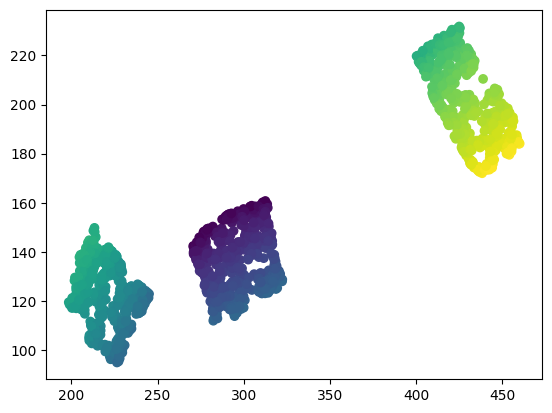

In [28]:
res = output.detach().cpu().numpy()
plt.scatter(x=res[:, 0], y=res[:, 1], c=color)

In [29]:
#绘制损失函数曲线
def draw_loss(Loss_list,epoch):
    # 我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
    plt.cla()
    x1 = range(1, epoch+1)
#     print(x1)
    y1 = Loss_list
#     print(y1)
    plt.title('Train loss vs. epoches', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('epoches', fontsize=20)
    plt.ylabel('Train loss', fontsize=20)
    plt.grid()
#     plt.savefig("./lossAndacc/Train_loss.png")
#     plt.savefig("./lossAndacc/Train_loss.png")
    plt.show()


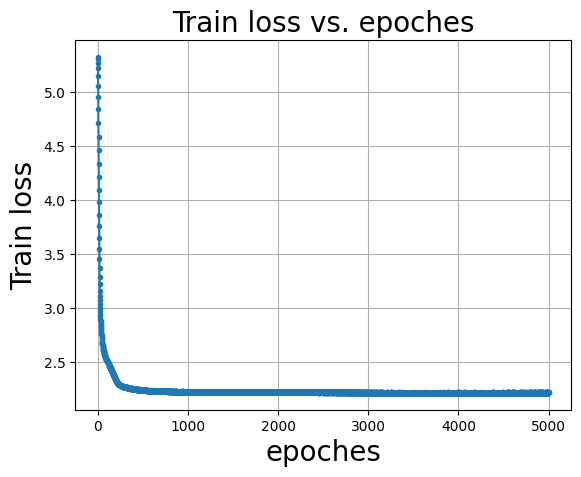

In [30]:
draw_loss(loss_list,max_iter)